In [ ]:
! pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 57.5 MB/s eta 0:00:00


https://www.kaggle.com/code/megalino111/deeplearningwithpython

# Pytorch

In [7]:
### General libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch

#Datasets from Pytorch
from torchvision.datasets import MNIST

#Stuff
from torchvision import transforms
from torch.utils.data import ConcatDataset, random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [13]:
save_model = True

In [2]:
#We get the dataset
#test_df= pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
#train_df= pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
transform = transforms.ToTensor()
root = os.getcwd()
dataset_train = MNIST(root=root, download=True, train=True, transform=transform)
dataset_test = MNIST(root=root, download=True, train=False, transform=transform)

print(dataset_train)
print(dataset_test)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.96MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: ToTensor()


Percentage training:  0.8571428571428571
Percentage test:  0.14285714285714285
Labels shape:  (70000,)
[6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


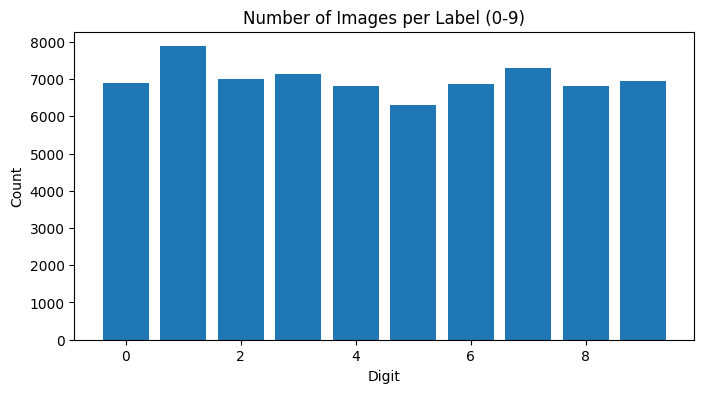

In [3]:
# Get labels as numpy array for stratification
labels_train = dataset_train.targets.numpy()
labels_test = dataset_test.targets.numpy()

labels = np.concatenate([labels_train,labels_test])
print("Percentage training: ", len(labels_train)/len(labels))
print("Percentage test: ", len(labels_test)/len(labels))

full_dataset = ConcatDataset([dataset_train, dataset_test])
print("Labels shape: ",labels.shape)
counts = np.bincount(labels, minlength=10)
print(counts)

plt.figure(figsize=(8, 4))
plt.bar(range(10), counts)
plt.title("Number of Images per Label (0-9)")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


Train labels:  [5522 6302 5592 5713 5459 5050 5501 5834 5460 5567]
Validation labels:  [691 788 699 714 682 631 687 730 682 696]
Test labels:  [690 787 699 714 683 632 688 729 683 695]


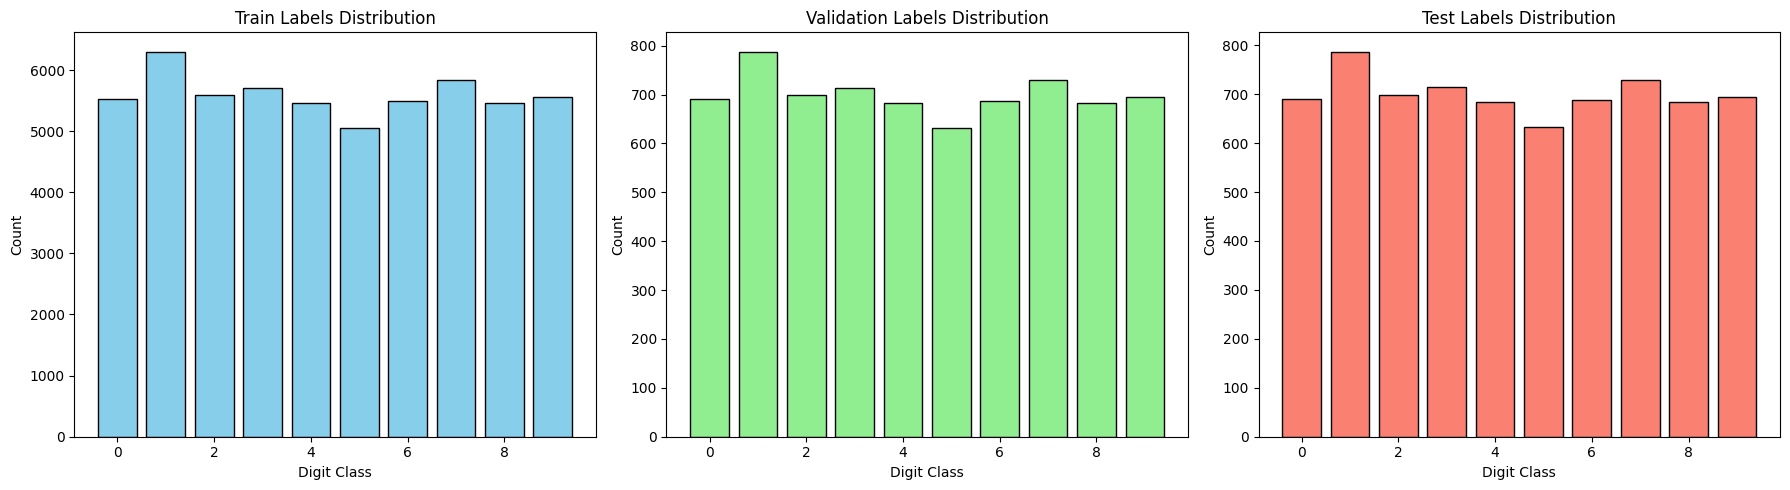

In [4]:
train_idx, temp_idx, _, temp_labels = train_test_split(
    range(len(full_dataset)), labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
train_labels = np.bincount(_, minlength=10)


val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

val_labels = np.bincount(val_labels, minlength=10)
test_labels = np.bincount(test_labels, minlength=10)


print("Train labels: ", train_labels)
print("Validation labels: ", val_labels)
print("Test labels: ", test_labels)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
classes = [0,1,2,3,4,5,6,7,8,9]

# Plot 1: Train Labels
axs[0].bar(classes, train_labels, color='skyblue', edgecolor='black')
axs[0].set_title('Train Labels Distribution')
axs[0].set_xlabel('Digit Class')
axs[0].set_ylabel('Count')

# Plot 2: Validation Labels
axs[1].bar(classes, val_labels, color='lightgreen', edgecolor='black')
axs[1].set_title('Validation Labels Distribution')
axs[1].set_xlabel('Digit Class')
axs[1].set_ylabel('Count')

# Plot 3: Test Labels
axs[2].bar(classes, test_labels, color='salmon', edgecolor='black')
axs[2].set_title('Test Labels Distribution')
axs[2].set_xlabel('Digit Class')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
test_ds  = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.misclassified = []  # list to store wrong images predictions

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_one_epoch():
    model.train()
    running_loss = 0
    running_acc = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x) #the result of the batch
        loss = F.cross_entropy(logits, y) #log_softmax(logits) and produces the error
        loss.backward() # Compute loss/weights for every parameter
        optimizer.step() #new_weight = old_weight − learning_rate * Adam_update(gradients) gradients = p.grad

        acc = (logits.argmax(1) == y).float().mean() #logits shape [batch_size, 10], Compute batch accuracy comparing the batch pixels with the y pixels
        running_loss += loss.item()
        running_acc += acc.item()

    return running_loss / len(train_loader), running_acc / len(train_loader)


def validate():
    model.eval()
    running_loss = 0
    running_acc = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            acc = (logits.argmax(1) == y).float().mean() # (logits.argmax(1) == y) return boolean array, float converts to 1.0 or 0.0

            running_loss += loss.item()
            running_acc += acc.item()

    return running_loss / len(val_loader), running_acc / len(val_loader)


def test():
    model.eval()
    running_acc = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            # there's no loss here
            preds = logits.argmax(1)
            acc = (preds == y).float().mean()
            running_acc += acc.item()

            # Store misclassified samples
            for img, pred, true in zip(x, preds, y):
                if pred != true:
                    model.misclassified.append((img.cpu(), pred.cpu(), true.cpu()))


    return running_acc / len(test_loader)


In [28]:
model = Net().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=1.0) # 1e-3 for Adam or 1.0 for Adadelta.
#Adadelta can work but is slower and less commonly used today.

#Adaptive Moment Estimation~ADAM
optimizer = optim.Adam(model.parameters(), lr=1e-3)  #model.parameters() provides the tensors (Weights and Biases) the optimizer must update during training


In [29]:
EPOCHS = 1

# Train, validate
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch()
    val_loss, val_acc = validate()

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


#Test to get the wrong images
final_test_acc = test()
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1/1
  Train Loss: 0.2218 | Train Acc: 0.9302
  Val   Loss: 0.0812 | Val   Acc: 0.9730

Final Test Accuracy: 0.9785


Image wrong classified: 150


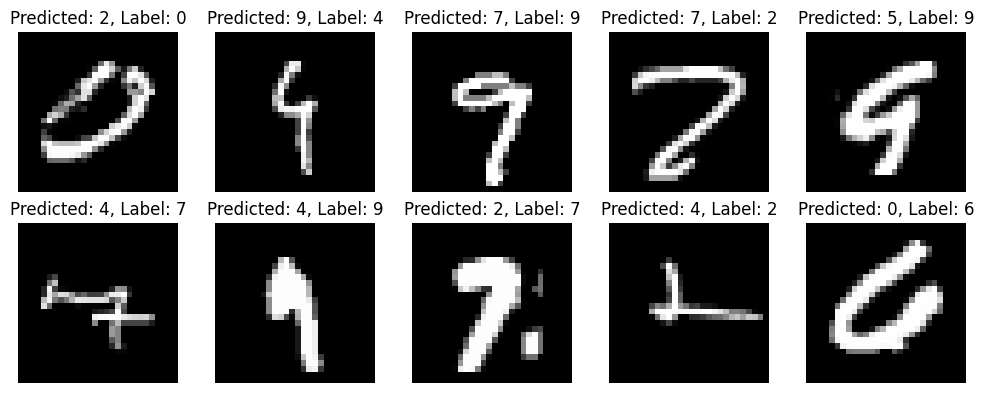

In [30]:
#check what images are the error in the accuracy week 3 10/Dic/2025
print("Image wrong classified:", len(model.misclassified))
#We will take the first 10
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4)) #2 x 5 figure

for i, ax in enumerate(axes.flat[:10]): #10 numbers
    img, pred, true = model.misclassified[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Predicted: {pred}, Label: {true}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

# PyTorch Lightning

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F

#PLOT
import matplotlib.pyplot as plt



In [ ]:

# ---------------------------------------------------------
# 1. Load MNIST dataset
# ---------------------------------------------------------
transform = transforms.ToTensor()
root = os.getcwd()

dataset = MNIST(root=root, download=True, train=True, transform=transform)

# Get labels as numpy array for stratification
labels = dataset.targets.numpy()
labels.shape



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 512kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


(60000,)

In [ ]:
# ---------------------------------------------------------
# 2. Stratified split: 80% train, 10% val, 10% test
# ---------------------------------------------------------
train_idx, temp_idx, _, temp_labels = train_test_split(
    range(len(dataset)), labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

val_idx, test_idx, _, _ = train_test_split(
    temp_idx, temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)
test_ds  = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True) #The batch describes how many steps will execute by epoch
val_loader   = DataLoader(val_ds, batch_size=64) #For example, here above we have the DataSet of 60000/64 = 937.5 ~ 938 training steps
test_loader  = DataLoader(test_ds, batch_size=64) # by epoch :)


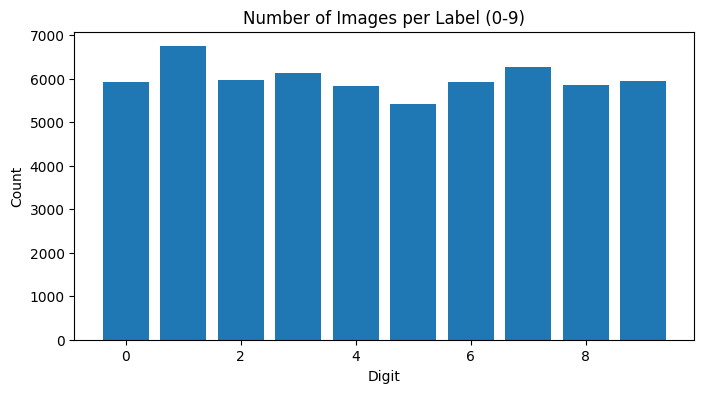

In [ ]:
# ---------------------------------------------------------
# 3. Visualization: number of images per label (0–9)
# ---------------------------------------------------------
import numpy as np

counts = np.bincount(labels, minlength=10)

plt.figure(figsize=(8, 4))
plt.bar(range(10), counts)
plt.title("Number of Images per Label (0-9)")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()



In [ ]:
# ---------------------------------------------------------
# 4. PyTorch Lightning CNN Model
# ---------------------------------------------------------
class LitCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.misclassified = []  # list to store wrong images predictions


        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # 14x14
            nn.Conv2d(32, 64, 3, padding=1), # 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2)               # 7x7
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = logits.argmax(dim=1)
        acc = (preds == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)


        # Store misclassified samples
        for img, pred, true in zip(x, preds, y):
            if pred != true:
                self.misclassified.append((img.cpu(), pred.cpu(), true.cpu()))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)



In [ ]:
# ---------------------------------------------------------
# 5. Train the model
# ---------------------------------------------------------
model = LitCNN()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv │ Sequential │ 18.8 K │ train │     0 │
│ 1 │ fc   │ Sequential │  402 K │ train │     0 │
└───┴──────┴────────────┴────────┴───────┴───────┘

Trainable params: 421 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 421 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 12                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# ---------------------------------------------------------
# 6. Test after training
# ---------------------------------------------------------
trainer.test(model, test_loader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9866666793823242     │
│         test_loss         │    0.04392063245177269    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04392063245177269, 'test_acc': 0.9866666793823242}]

Image wrong classified: 240


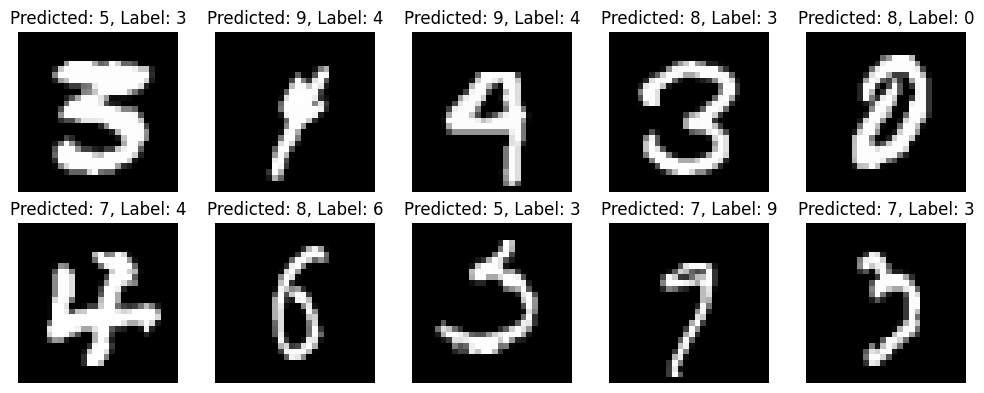

In [ ]:
#check what images are the error in the accuracy week 3 10/Dic/2025
print("Image wrong classified:", len(model.misclassified))
#We will take the first 10
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4)) #2 x 5 figure

for i, ax in enumerate(axes.flat[:10]): #10 numbers
    img, pred, true = model.misclassified[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Predicted: {pred}, Label: {true}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# ---------------------------------------------------------
# 7. Plot training & validation metrics
# ---------------------------------------------------------

# --- LOSS CURVE ---
plt.figure(figsize=(8, 4))
plt.plot(model.train_losses, label="Train Loss")
plt.plot(model.val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- ACCURACY CURVE ---
plt.figure(figsize=(8, 4))
plt.plot(model.train_accs, label="Train Accuracy")
plt.plot(model.val_accs, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

# ---------------------------------------------------------
# 8. Second training run using Early Stopping
# ---------------------------------------------------------

early_stop_callback = EarlyStopping(
    monitor="val_loss",     # the metric to monitor
    patience=3,             # stop if no improvement in 3 epochs
    mode="min",             # val_loss should decrease
    verbose=True
)


model_es = LitCNN()  # new instance with fresh parameters

trainer_es = pl.Trainer(
    max_epochs=20,          # can be high; early stopping will stop automatically
    callbacks=[early_stop_callback]
)

print("Starting second training with Early Stopping...")
trainer_es.fit(model_es, train_loader, val_loader)

print("Testing model trained with Early Stopping...")
trainer_es.test(model_es, test_loader)


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 1 TPU cores


Starting second training with Early Stopping...


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv │ Sequential │ 18.8 K │ train │     0 │
│ 1 │ fc   │ Sequential │  402 K │ train │     0 │
└───┴──────┴────────────┴────────┴───────┴───────┘

Trainable params: 421 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 421 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 12                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.070
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.053
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.041
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.040
INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.040. Signaling Trainer to stop.


Output()

Testing model trained with Early Stopping...


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9856666326522827     │
│         test_loss         │    0.0609859861433506     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0609859861433506, 'test_acc': 0.9856666326522827}]

Training Loss:  751
Validation Loss:  96


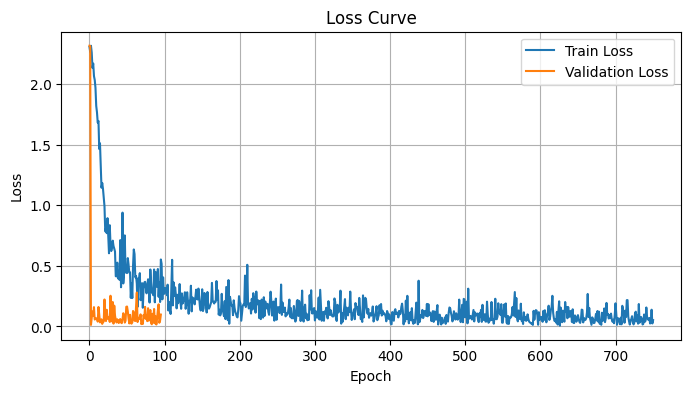

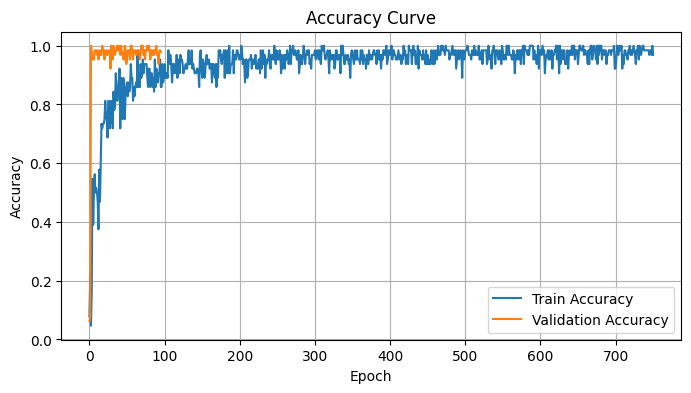

In [ ]:
plt.figure(figsize=(8, 4))
print("Training Loss: ", len(model.train_losses))
print("Validation Loss: ", len(model.val_losses))
plt.plot(model.train_losses, label="Train Loss")
plt.plot(model.val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- ACCURACY CURVE ---
plt.figure(figsize=(8, 4))
plt.plot(model.train_accs, label="Train Accuracy")
plt.plot(model.val_accs, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

check what images are the error in the accuracy